In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

### Clean the data

In [2]:
# Read the NYC weather data
df = pd.read_csv('nyc_weather.csv')

# Keep only the specified columns
columns_to_keep = ['STATION', 'NAME', 'DATE', 'TMAX', 'TMIN']
df = df[columns_to_keep].copy()

# Convert DATE to datetime - ensure proper conversion
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d', errors='coerce')

# Drop any rows where DATE conversion failed
df = df.dropna(subset=['DATE'])

# Sort by date
df = df.sort_values('DATE')

# Create features for time
df['year'] = df['DATE'].dt.year
df['month'] = df['DATE'].dt.month
df['day'] = df['DATE'].dt.day
df['day_of_week'] = df['DATE'].dt.dayofweek

# Fill null values with column means
df['TMAX'] = df['TMAX'].fillna(df['TMAX'].mean())
df['TMIN'] = df['TMIN'].fillna(df['TMIN'].mean())

# Create clean dataframe
clean_df = df.copy()


clean_df.head()

,STATION,NAME,DATE,TMAX,TMIN,year,month,day,day_of_week
0,USW00094728,"NY CITY CENTRAL PARK, NY US",1869-12-01,62,33,1869,12,1,2
1,USW00094728,"NY CITY CENTRAL PARK, NY US",1869-12-02,33,24,1869,12,2,3
2,USW00094728,"NY CITY CENTRAL PARK, NY US",1869-12-03,29,16,1869,12,3,4
3,USW00094728,"NY CITY CENTRAL PARK, NY US",1869-12-04,37,15,1869,12,4,5
4,USW00094728,"NY CITY CENTRAL PARK, NY US",1869-12-05,39,35,1869,12,5,6


### Normalize Data

In [3]:
# Select features for the model
feature_columns = ['TMAX', 'TMIN', 'year', 'month', 'day', 'day_of_week']

# Normalize the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[feature_columns])
scaled_df = pd.DataFrame(scaled_data, columns=feature_columns)

scaled_df.head()

,TMAX,TMIN,year,month,day,day_of_week
0,0.576923,0.470588,0.0,1.0,0.000000,0.333333
1,0.298077,0.382353,0.0,1.0,0.033333,0.500000
2,0.259615,0.303922,0.0,1.0,0.066667,0.666667
3,0.336538,0.294118,0.0,1.0,0.100000,0.833333
4,0.355769,0.490196,0.0,1.0,0.133333,1.000000


### Visualize Data

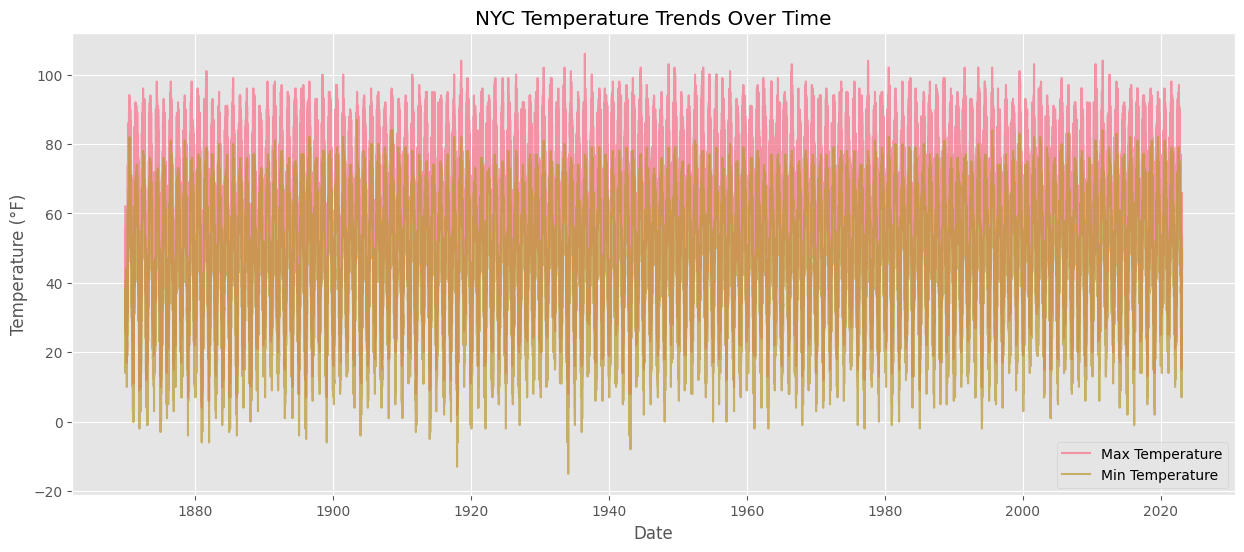

<Figure size 1200x600 with 0 Axes>

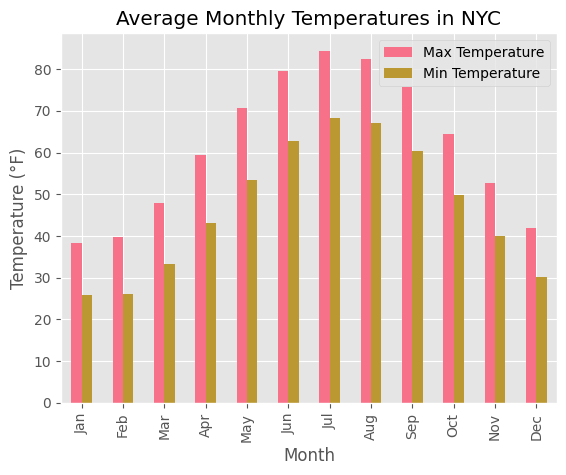

In [4]:
# Set the style for better visualizations
plt.style.use('ggplot')  # Using ggplot style instead of seaborn
sns.set_palette("husl")

# Plot temperature trends over time
plt.figure(figsize=(15, 6))
plt.plot(df['DATE'], df['TMAX'], label='Max Temperature', alpha=0.7)
plt.plot(df['DATE'], df['TMIN'], label='Min Temperature', alpha=0.7)
plt.title('NYC Temperature Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.grid(True)
plt.show()

# Plot monthly average temperatures
monthly_avg = df.groupby('month')[['TMAX', 'TMIN']].mean()
plt.figure(figsize=(12, 6))
monthly_avg.plot(kind='bar')
plt.title('Average Monthly Temperatures in NYC')
plt.xlabel('Month')
plt.ylabel('Temperature (°F)')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(['Max Temperature', 'Min Temperature'])
plt.grid(True)
plt.show()

### time series decomposition analysis

/var/folders/z_/z58m8krd6bx8rcfklwvr7psc0000gn/T/ipykernel_56431/4079104982.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_tmax = df.set_index('DATE')['TMAX'].resample('M').mean()


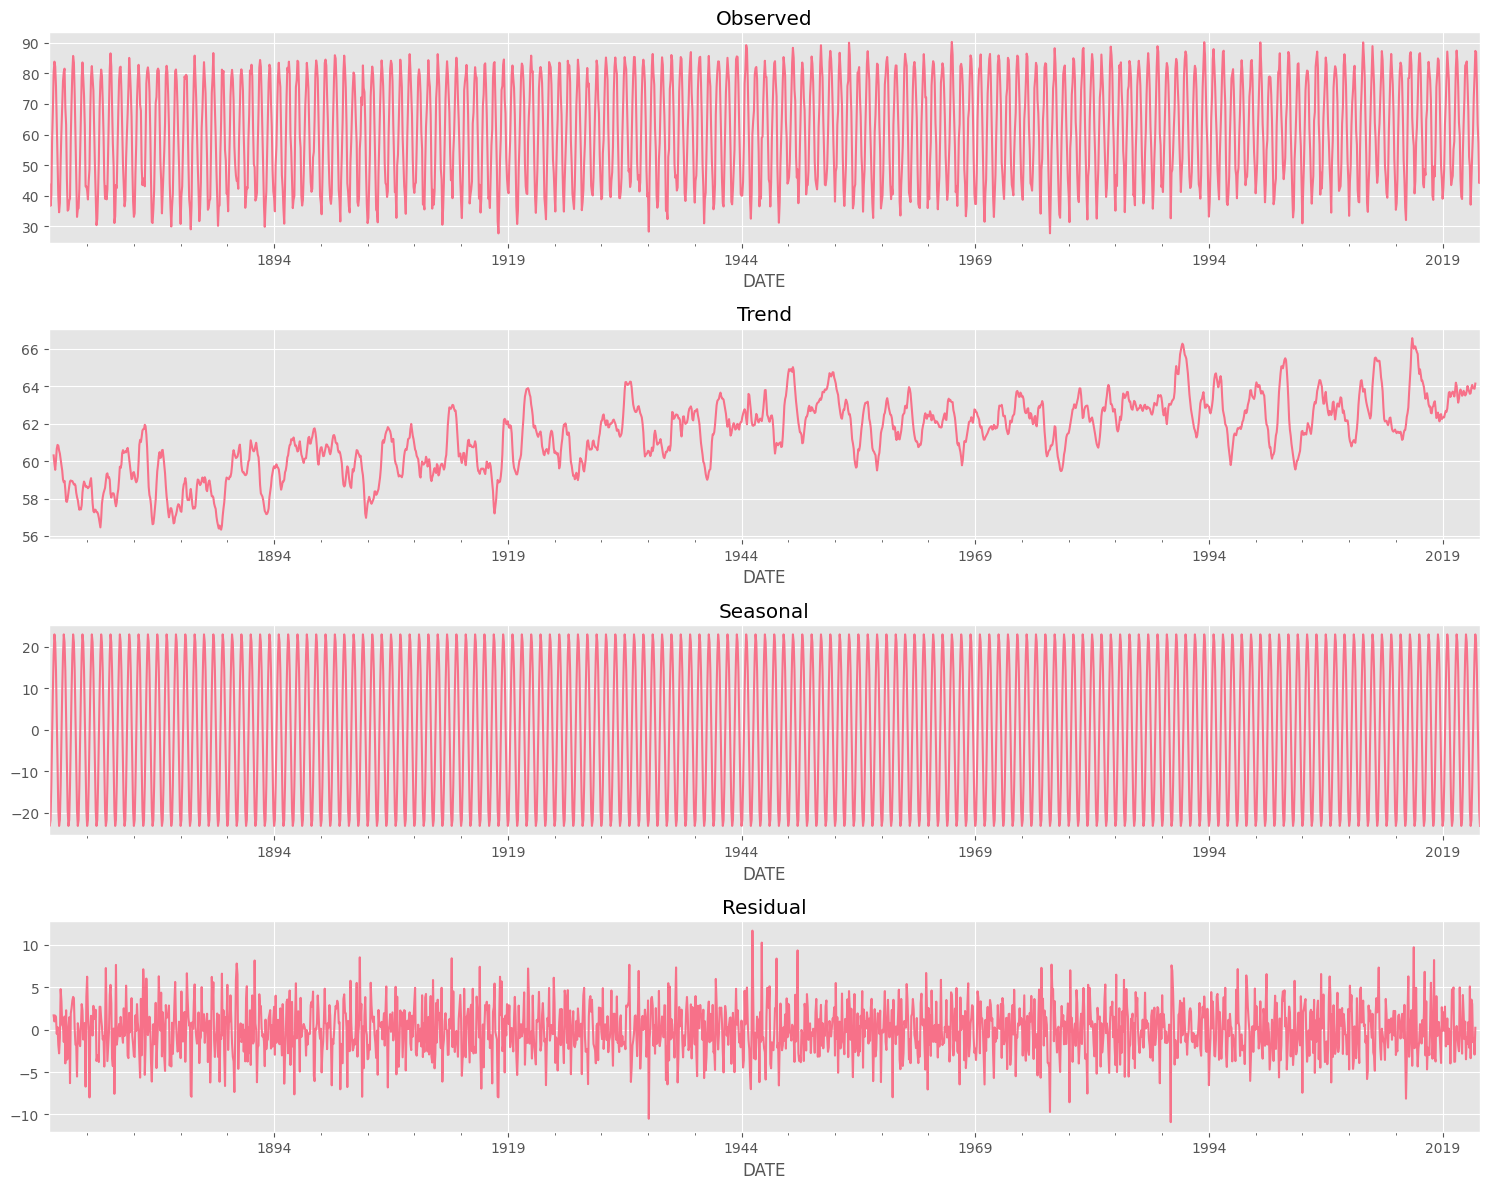

In [5]:
# Perform time series decomposition on max temperature
monthly_tmax = df.set_index('DATE')['TMAX'].resample('M').mean()
decomposition = seasonal_decompose(monthly_tmax, period=12)

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

### Adding time-based features

In [6]:
# Create additional time-based features
df['day_of_year'] = df['DATE'].dt.dayofyear
df['quarter'] = df['DATE'].dt.quarter
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Create lag features
df['TMAX_lag1'] = df['TMAX'].shift(1)
df['TMIN_lag1'] = df['TMIN'].shift(1)

# Create rolling window features
df['TMAX_7d_avg'] = df['TMAX'].rolling(window=7, min_periods=1).mean()
df['TMIN_7d_avg'] = df['TMIN'].rolling(window=7, min_periods=1).mean()

# Update feature columns
feature_columns = ['TMAX', 'TMIN', 'year', 'month', 'day', 'day_of_week',
                  'day_of_year', 'quarter', 'is_weekend', 'TMAX_lag1', 'TMIN_lag1',
                  'TMAX_7d_avg', 'TMIN_7d_avg']

# Normalize the expanded feature set
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[feature_columns])
scaled_df = pd.DataFrame(scaled_data, columns=feature_columns)

scaled_df.head()

,TMAX,TMIN,year,month,day,day_of_week,day_of_year,quarter,is_weekend,TMAX_lag1,TMIN_lag1,TMAX_7d_avg,TMIN_7d_avg
0,0.576923,0.470588,0.0,1.0,0.000000,0.333333,0.915068,1.0,0.0,NaN,NaN,0.590690,0.447099
1,0.298077,0.382353,0.0,1.0,0.033333,0.500000,0.917808,1.0,0.0,0.576923,0.470588,0.427769,0.393345
2,0.259615,0.303922,0.0,1.0,0.066667,0.666667,0.920548,1.0,0.0,0.298077,0.382353,0.358480,0.343572
3,0.336538,0.294118,0.0,1.0,0.100000,0.833333,0.923288,1.0,1.0,0.259615,0.303922,0.346308,0.315700
4,0.355769,0.490196,0.0,1.0,0.133333,1.000000,0.926027,1.0,1.0,0.336538,0.294118,0.343499,0.346758


### Create the TimeSeriesDataset class

In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length, target_cols=['TMAX', 'TMIN']):
        self.data = torch.FloatTensor(data)
        self.seq_length = seq_length
        self.target_cols = target_cols
        
    def __len__(self):
        return len(self.data) - self.seq_length
        
    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length]
        y = self.data[idx + self.seq_length, :len(self.target_cols)]
        return x, y

# Prepare data
seq_length = 30  # Use 30 days of history
target_cols = ['TMAX', 'TMIN']

# Split data
train_size = int(len(scaled_df) * 0.8)
train_data = scaled_df[:train_size]
test_data = scaled_df[train_size:]

# Create datasets
train_dataset = TimeSeriesDataset(train_data.values, seq_length, target_cols)
test_dataset = TimeSeriesDataset(test_data.values, seq_length, target_cols)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Define and train the RNN model

In [ ]:
class WeatherRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(WeatherRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Initialize model
input_size = len(feature_columns)
hidden_size = 64
num_layers = 2
output_size = len(target_cols)

model = WeatherRNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Evaluate
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            test_loss += criterion(outputs, batch_y).item()
    
    train_losses.append(train_loss / len(train_loader))
    test_losses.append(test_loss / len(test_loader))
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss/len(train_loader):.4f}, '
              f'Test Loss: {test_loss/len(test_loader):.4f}')

Epoch [10/50], Train Loss: nan, Test Loss: nan
Epoch [20/50], Train Loss: nan, Test Loss: nan


### Evaluation and visualization of results

NaN values in scaled_df:
TMAX           0
TMIN           0
year           0
month          0
day            0
day_of_week    0
day_of_year    0
quarter        0
is_weekend     0
TMAX_lag1      1
TMIN_lag1      1
TMAX_7d_avg    0
TMIN_7d_avg    0
dtype: int64

After cleaning, NaN values in scaled_df:
TMAX           0
TMIN           0
year           0
month          0
day            0
day_of_week    0
day_of_year    0
quarter        0
is_weekend     0
TMAX_lag1      0
TMIN_lag1      0
TMAX_7d_avg    0
TMIN_7d_avg    0
dtype: int64


/var/folders/z_/z58m8krd6bx8rcfklwvr7psc0000gn/T/ipykernel_54337/3949705456.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  scaled_df = scaled_df.fillna(method='ffill')  # Forward fill
/var/folders/z_/z58m8krd6bx8rcfklwvr7psc0000gn/T/ipykernel_54337/3949705456.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  scaled_df = scaled_df.fillna(method='bfill')  # Backward fill for any remaining NaNs


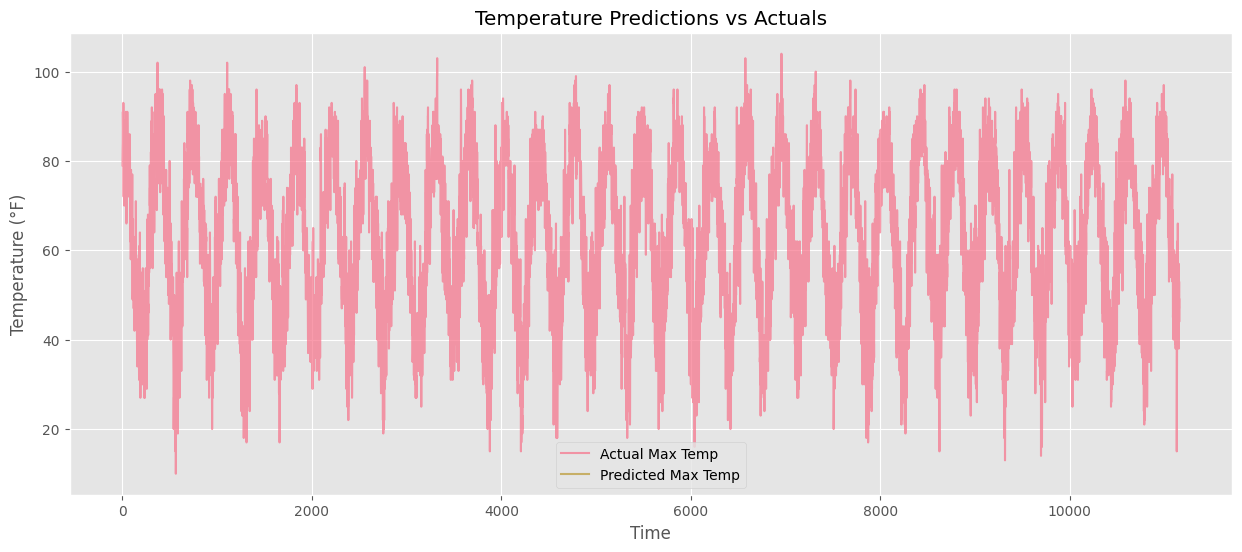

ValueError: Input contains NaN.

In [9]:
# Check for NaN values in the data
print("NaN values in scaled_df:")
print(scaled_df.isna().sum())

# Make sure we don't have any NaN values in our data
scaled_df = scaled_df.fillna(method='ffill')  # Forward fill
scaled_df = scaled_df.fillna(method='bfill')  # Backward fill for any remaining NaNs

# Verify no NaN values remain
print("\nAfter cleaning, NaN values in scaled_df:")
print(scaled_df.isna().sum())

# Update the make_predictions function to handle NaN values
def make_predictions(model, data_loader, scaler, target_cols):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            # Check for NaN values in input
            if torch.isnan(batch_x).any() or torch.isnan(batch_y).any():
                print("Warning: NaN values found in batch")
                continue
                
            outputs = model(batch_x)
            predictions.extend(outputs.numpy())
            actuals.extend(batch_y.numpy())
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Create a dummy array for inverse transform
    dummy_array = np.zeros((predictions.shape[0], len(feature_columns)))
    dummy_array[:, :len(target_cols)] = predictions
    
    # Inverse transform predictions
    predictions_original = scaler.inverse_transform(dummy_array)[:, :len(target_cols)]
    
    # Create a dummy array for actuals
    dummy_array = np.zeros((actuals.shape[0], len(feature_columns)))
    dummy_array[:, :len(target_cols)] = actuals
    
    # Inverse transform actuals
    actuals_original = scaler.inverse_transform(dummy_array)[:, :len(target_cols)]
    
    return predictions_original, actuals_original

# Get predictions
predictions, actuals = make_predictions(model, test_loader, scaler, target_cols)

# Plot predictions vs actuals
plt.figure(figsize=(15, 6))
plt.plot(actuals[:, 0], label='Actual Max Temp', alpha=0.7)
plt.plot(predictions[:, 0], label='Predicted Max Temp', alpha=0.7)
plt.title('Temperature Predictions vs Actuals')
plt.xlabel('Time')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

for i, col in enumerate(target_cols):
    mse = mean_squared_error(actuals[:, i], predictions[:, i])
    mae = mean_absolute_error(actuals[:, i], predictions[:, i])
    r2 = r2_score(actuals[:, i], predictions[:, i])
    
    print(f'\nMetrics for {col}:')
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'Mean Absolute Error: {mae:.2f}')
    print(f'R² Score: {r2:.2f}')